In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [10]:
# loading the dataset
sales = pd.read_csv('datasets/Alcohol_Sales.csv', header=0, index_col=0)
values = sales.values

sales

,SALES
DATE,
01-01-1992,3459
01-02-1992,3458
01-03-1992,4002
01-04-1992,4564
01-05-1992,4221
...,...
01-09-2018,12396
01-10-2018,13914
01-11-2018,14174


In [12]:
sales.describe()

,SALES
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


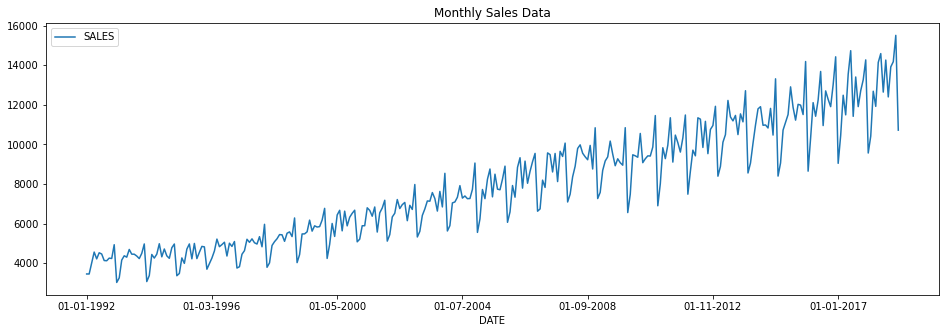

In [16]:
sales.plot(figsize=(16,5))
plt.title('Monthly Sales Data')
plt.show()

In [52]:
# Splitting data into train and test
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [4]:
# Function to convert timeseries data into supervised data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # Will take input as times series data
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [64]:
data = series_to_supervised(values, n_in=29) # Converting data into supervised dataset with 

In [65]:
data

array([[ 3459.,  3458.,  4002., ...,  4261.,  4460.,  4985.],
       [ 3458.,  4002.,  4564., ...,  4460.,  4985.,  4324.],
       [ 4002.,  4564.,  4221., ...,  4985.,  4324.,  4719.],
       ...,
       [13681., 10950., 12700., ..., 12396., 13914., 14174.],
       [10950., 12700., 12272., ..., 13914., 14174., 15504.],
       [12700., 12272., 11905., ..., 14174., 15504., 10718.]])

In [36]:
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [53]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset into train and test
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
    # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on previous values and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to previous values for the next loop
        history.append(test[i])
        # summarize progress
        print('expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = np.sqrt(mean_squared_error(test[:, -1], predictions))
    return error, test[:, -1], predictions

In [66]:
rmse, y, yhat = walk_forward_validation(data,29) # Predicts that much predictions as passed in the function... Here it is 7

expected=12272.0, predicted=12645.1
expected=11905.0, predicted=11830.5
expected=13016.0, predicted=12052.1
expected=14421.0, predicted=14086.2
expected=9043.0, predicted=9233.1
expected=10452.0, predicted=11874.9
expected=12481.0, predicted=12095.2
expected=11491.0, predicted=11250.1
expected=13545.0, predicted=12814.1
expected=14730.0, predicted=13878.5
expected=11416.0, predicted=10480.3
expected=13402.0, predicted=13120.2
expected=11907.0, predicted=13550.4
expected=12711.0, predicted=12167.6
expected=13261.0, predicted=13459.0
expected=14265.0, predicted=13750.1
expected=9564.0, predicted=9455.2
expected=10415.0, predicted=11951.4
expected=12683.0, predicted=11907.8
expected=11919.0, predicted=11264.6
expected=14138.0, predicted=13802.4
expected=14583.0, predicted=14365.5
expected=12640.0, predicted=11774.4
expected=14257.0, predicted=13773.8
expected=12396.0, predicted=12904.6
expected=13914.0, predicted=13501.6
expected=14174.0, predicted=14040.8
expected=15504.0, predicted=1418

In [67]:
print("RMSE value is",rmse)

RMSE value is 756.4358810173024


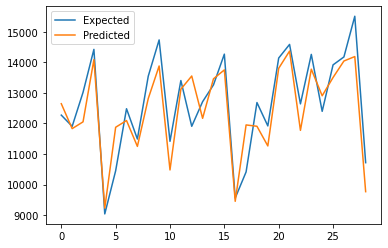

In [68]:
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()